In [1]:
class parent:
    def hi(self):
        print("Hello")
    def get_money(self):
        print("상속")

class child(parent):
    # method overriding
    def hi(self):
        super().hi()
        print("나는 자식입니다.")

instance_a = child()

In [2]:
instance_a.hi()

Hello
나는 자식입니다.


In [3]:
instance_a.get_money()

상속


In [4]:
import torch 
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np
import h5py

In [5]:
class Happy_Data(Dataset):
    def __init__(self, train_path, type_="test"):
        train_happy = h5py.File(train_path, 'r')
        if type_ == 'train':
            # print(len(train_happy['train_set_x'][:]))
            self.X_data  = np.array(train_happy['train_set_x'][:])
            self.y_data  = np.array(train_happy['train_set_y'][:])
        elif type_ == 'test':
            # print(len(train_happy['test_set_x'][:]))
            self.X_data  = np.array(train_happy['test_set_x'][:])
            self.y_data  = np.array(train_happy['test_set_y'][:])
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            # transofrms.Normalize((R채널 평균, G채널 평균, B채널 평균), (R채널 표준편차, G채널 표준편차, B채널 표준편차))
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
    
    def __getitem__(self, idx):
        return self.transform(self.X_data[idx]) , torch.tensor(self.y_data[idx], dtype=torch.float32)

    def __len__(self):
        return len(self.X_data)

In [6]:
train = Happy_Data("./data/train_happy.h5", "train")

In [7]:
len(train)

600

In [8]:
test = Happy_Data("./data/test_happy.h5", "test")

In [9]:
len(test)

150

In [10]:
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test,  batch_size=32, shuffle=True)

In [11]:
tmp = next(iter(train_loader))

In [12]:
tmp[0].shape

torch.Size([32, 3, 64, 64])

In [13]:
tmp[1]

tensor([0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1.,
        0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0.])

In [14]:
import torch.nn as nn

In [15]:
import torch.nn.functional as F
class CnnHappy(nn.Module):
    def __init__(self):
        super(CnnHappy, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1   = nn.Linear(16 * 16 * 16, 128)
        self.fc2   = nn.Linear(128, 32)
        self.fc3   = nn.Linear(32,1)

    def forward(self, x):
        # CNN
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        #DNN 
        x = self.fc1(x.view(-1, 16* 16* 16))
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.sigmoid(x)

        return x

In [16]:
model = CnnHappy()
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
600 / 32

18.75

In [18]:
600 % 32

24

In [19]:

def train(model, train_loader, optimizer, log_interval):
    global label, preds, loss
    model.train()
    for batch_idx, (image, label)  in enumerate(train_loader):
        optimizer.zero_grad()
        preds = model(image)
        loss = loss_fn(preds, label.view(-1,1))
        loss.backward()
        optimizer.step()


In [20]:
for epoch in range(1, 11):
    train(model, train_loader, optimizer, log_interval=3)
    break

In [21]:
preds.round()

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], grad_fn=<RoundBackward0>)

In [22]:
(preds.round() == label.view(-1, 1)).sum()

tensor(12)

In [23]:
label.view(-1, 1)

tensor([[0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.]])

In [24]:
len(train_loader)

19

In [25]:
def train(model, train_loader, test_loader, optimizer, epochs, log_interval):
    #global label, preds
    loss_hist_train       = [0] * epochs
    accuracy_hist_train   = [0] * epochs
    loss_hist_valid       = [0] * epochs
    accuracy_hist_valid   = [0] * epochs
    for epoch in range(epochs):
        # 훈련
        model.train()
        for batch_idx, (image, label)  in enumerate(train_loader):
            optimizer.zero_grad()
            preds = model(image)
            loss = loss_fn(preds, label.view(-1,1))
            loss.backward()
            optimizer.step()
            
            loss_hist_train[epoch] += loss.item() * label.size(0)
            is_correct = (preds.round() == label.view(-1, 1)).sum().float()
            # print(is_correct)
            accuracy_hist_train[epoch] += is_correct.sum()

        # print(accuracy_hist_train[epoch])
        # print( f"train_loader {len(train_loader.dataset)} " )
        accuracy_hist_train[epoch] /= len(train_loader.dataset)
        # print(accuracy_hist_train[epoch])
        loss_hist_train[epoch] /= len(train_loader.dataset)

        # 평가 
        model.eval()
        with torch.no_grad():
            for batch_idx, (image, label)  in enumerate(test_loader):
                preds = model(image)
                loss = loss_fn(preds, label.view(-1,1))
                loss_hist_valid[epoch] += loss.item() * label.size(0)
                is_correct = (preds.round() == label.view(-1, 1)).sum().float()
                accuracy_hist_valid[epoch] += is_correct.sum()
                
        accuracy_hist_valid[epoch] /= len(test_loader.dataset)
        loss_hist_valid[epoch] /= len(test_loader.dataset)

        print(f"에폭 {epoch+1}  정확도 : {accuracy_hist_train[epoch]:.4f} 검증 정확도 : {accuracy_hist_valid[epoch]:.4f}")
    return loss_hist_train, accuracy_hist_train , loss_hist_valid, accuracy_hist_valid 

model, train_loader, test_loader, optimizer, epochs, log_interval

In [26]:
model = CnnHappy()
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
hist = train(model,  train_loader, test_loader, optimizer, 15, log_interval=1)

에폭 1  정확도 : 0.6033 검증 정확도 : 0.7267
에폭 2  정확도 : 0.7850 검증 정확도 : 0.7800
에폭 3  정확도 : 0.8717 검증 정확도 : 0.8933
에폭 4  정확도 : 0.8950 검증 정확도 : 0.9133
에폭 5  정확도 : 0.9483 검증 정확도 : 0.9200
에폭 6  정확도 : 0.9500 검증 정확도 : 0.9333
에폭 7  정확도 : 0.9617 검증 정확도 : 0.9467
에폭 8  정확도 : 0.9633 검증 정확도 : 0.9600
에폭 9  정확도 : 0.9750 검증 정확도 : 0.9667
에폭 10  정확도 : 0.9600 검증 정확도 : 0.9400
에폭 11  정확도 : 0.9767 검증 정확도 : 0.9267
에폭 12  정확도 : 0.9717 검증 정확도 : 0.8333
에폭 13  정확도 : 0.9667 검증 정확도 : 0.9533
에폭 14  정확도 : 0.9700 검증 정확도 : 0.9067
에폭 15  정확도 : 0.9733 검증 정확도 : 0.9600


In [27]:
loss_hist_train, accuracy_hist_train , loss_hist_valid, accuracy_hist_valid = hist

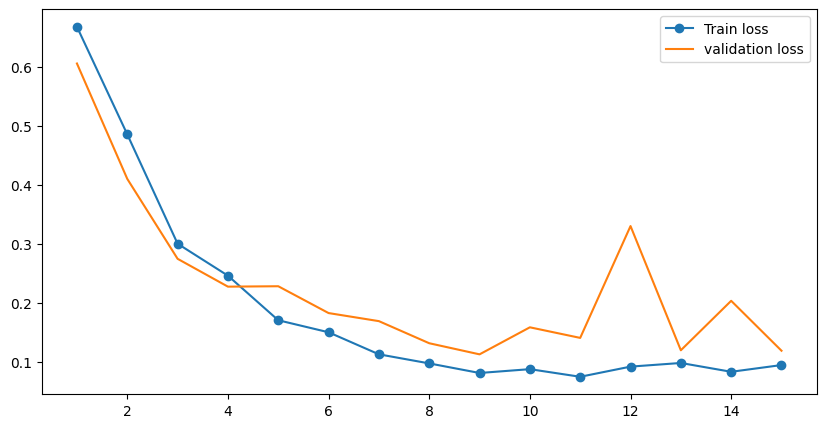

In [28]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10,5))

x_arr = np.arange(len(loss_hist_train)) + 1

plt.plot(x_arr, loss_hist_train, '-o', label='Train loss')
plt.plot(x_arr, loss_hist_valid, label='validation loss')
plt.legend()
plt.show()


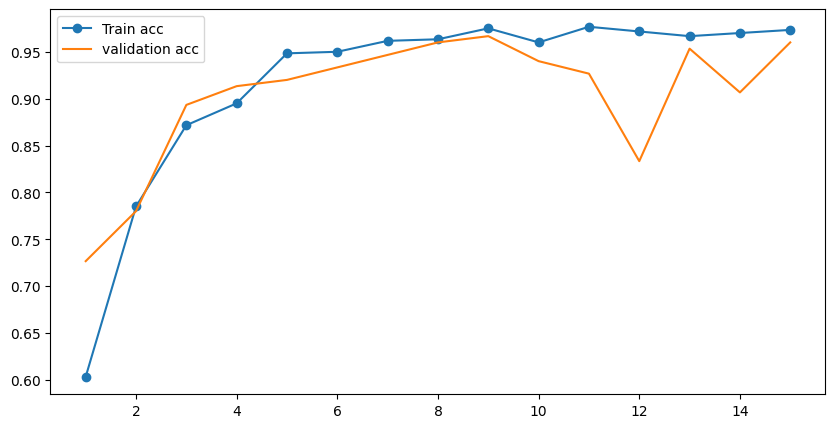

In [29]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10,5))

x_arr = np.arange(len(loss_hist_train)) + 1

plt.plot(x_arr, accuracy_hist_train, '-o', label='Train acc')
plt.plot(x_arr, accuracy_hist_valid, label='validation acc')
plt.legend()
plt.show()

In [30]:
label.size(0)

24

In [31]:
label.view(-1,1).shape

torch.Size([24, 1])

In [32]:
preds.shape

torch.Size([24, 1])

In [33]:
label.dtype

torch.float32

In [34]:
preds.dtype

torch.float32